# Predictive Maintenance

In [2]:
# import the required libraries
import pandas as pd
from ydata_profiling import  ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score, recall_score roc_auc_score, precision_score
from ydata_profiling import ProfileReport
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [3]:
# load the dataset

df = pd.read_csv('ai4i2020.csv')
#This dataset is part of the following publication: 
#S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 
#Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74:.

In [18]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
# rename dataset columns
df.rename(columns = {'Air temperature [K]':'Air_temperature',
                     'Process temperature [K]':'Process_temperature',
                     'Rotational speed [rpm]':'Rotational_speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool_wear',
                     'Machine failure' : 'Machine_failure'},
          inplace = True)

In [6]:
# drop UDI and Product ID columns
df.drop(['Product ID', 'UDI'], axis='columns', inplace = True)

In [7]:
df.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
df.isnull().sum()

Type                   0
Air_temperature        0
Process_temperature    0
Rotational_speed       0
Torque                 0
Tool_wear              0
Machine_failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

In [7]:
df[['Machine_failure','HDF','TWF','PWF','OSF','RNF']].value_counts().reset_index(name='count')


,Machine_failure,HDF,TWF,PWF,OSF,RNF,count
0,0,0,0,0,0,0,9643
1,1,1,0,0,0,0,106
2,1,0,0,1,0,0,80
3,1,0,0,0,1,0,78
4,1,0,1,0,0,0,42
5,0,0,0,0,0,1,18
6,1,0,0,1,1,0,11
7,1,0,0,0,0,0,9
8,1,1,0,0,1,0,6
9,1,1,0,1,0,0,3


In [8]:
df.loc[df['RNF'] == 1, 'Machine_failure'] = 1
#drop fail types, not much variance
df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)



In [9]:
prof = ProfileReport(df)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Machine_failure', ylabel='count'>

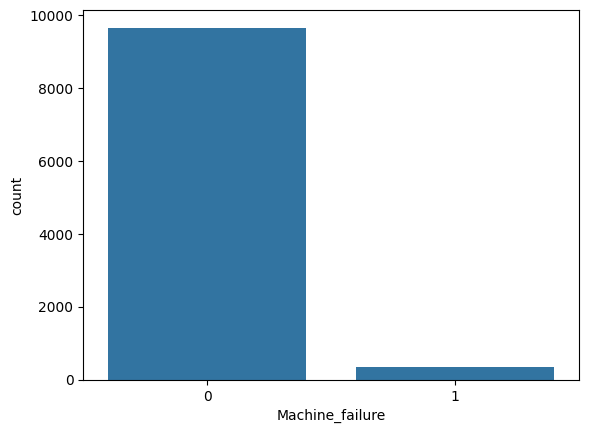

In [ ]:
sns.countplot(x='Machine_failure', data=df)


In [ ]:
df.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [9]:
df['Machine_failure'].value_counts()
failed = len(df[df['Machine_failure'] == 1])
not_failed = len(df[df['Machine_failure'] == 0])
class_ratio = print('Proportion:', round(failed / not_failed, 2)*100, '%')

class_ratio


Machine_failure
0    9643
1     357
Name: count, dtype: int64

Proportion: 4.0 %


In [22]:
numerical= df.select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque',
       'Tool_wear', 'Machine_failure'],
      dtype='object')


Categorical Columns: Index(['Type'], dtype='object')


<Axes: >

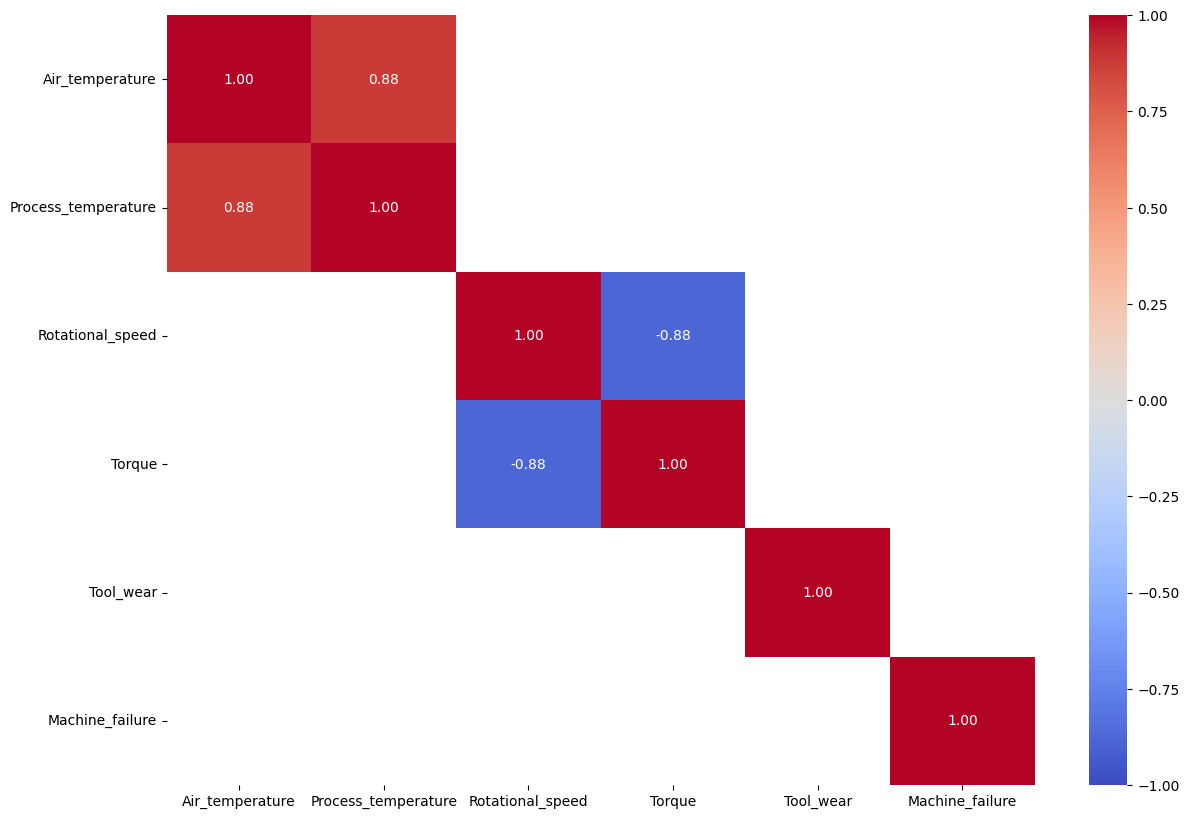

In [ ]:
matrix = df[numerical].corr().where((abs(df[numerical].corr()) >=0.3)).isna()
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax)

In [ ]:
df.describe()


,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,Power
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,0.500300,300.004930,310.005560,1538.776100,39.986910,107.951000,0.03570,59967.147040
std,0.671301,2.000259,1.483734,179.284096,9.968934,63.654147,0.18555,10193.093881
min,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.00000,10966.800000
25%,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.00000,53105.400000
50%,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.00000,59883.900000
75%,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.00000,66873.750000
max,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.00000,99980.400000


In [6]:
#Highly imbalanced data

df['Type'] = df['Type'].replace(['L', 'M', 'H'], [1, 2, 3])
#Adding power feature
df['Power']=df['Rotational_speed']*df['Torque']



In [7]:
df = shuffle(df)
X= df.drop('Machine_failure', axis='columns')
y= df['Machine_failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Dealing with imbalanced data

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7000, 7)
(3000, 7)


In [ ]:
X_train.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power
1724,M,298.3,307.8,1457,52.5,98,76492.5
4974,L,303.8,312.7,1414,41.7,190,58963.8
4707,L,303.5,311.8,1944,23.5,159,45684.0
2645,H,299.9,309.5,1547,38.5,148,59559.5
8281,H,298.9,310.6,1519,38.8,213,58937.2


In [ ]:
numerical= X_train.select_dtypes('number').columns
categorical = X_train.select_dtypes('object').columns


In [26]:

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

numeric_features = X_train[numerical].columns
categorical_features = X_train[ categorical].columns

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    verbose_feature_names_out = False
)

In [27]:
X_train_processed=pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
X_test_processed=pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

In [28]:
X_train_processed.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power
0,0.760844,-0.908712,-0.681300,-0.548950,0.423723,0.609849,0.366090
1,-0.745778,0.740739,0.399195,-0.273623,0.814770,-0.425377,1.147691
2,-0.745778,0.640773,0.736849,-0.194959,-0.087646,-1.664513,-0.112641
3,0.760844,0.840706,0.534257,-0.082580,0.132944,0.609849,0.292504
4,-0.745778,-0.908712,-1.424141,-0.784944,1.496595,0.484367,1.650948


In [ ]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 7000 non-null   float64
 1   Air_temperature      7000 non-null   float64
 2   Process_temperature  7000 non-null   float64
 3   Rotational_speed     7000 non-null   float64
 4   Torque               7000 non-null   float64
 5   Tool_wear            7000 non-null   float64
 6   Power                7000 non-null   float64
dtypes: float64(7)
memory usage: 382.9 KB


In [ ]:
accuracy= []
recall =[]
f1_score= []
precision = []
#Adjusting scale_pos_weight in Light GBM to deal with Imbalance data
lgb = LGBMClassifier(boosting_type='gbdt',random_state=42,scale_pos_weight=5)

lgb.fit(X_train, y_train,eval_set=(X_test, y_test))

y_pred = lgb.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
#f1_score.append(round(f1_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_adjusted']
result_df8 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Precision':precision}, index=model_names)
result_df8

[LightGBM] [Info] Number of positive: 252, number of negative: 6748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036000 -> initscore=-3.287572
[LightGBM] [Info] Start training from score -3.287572


,Accuracy,Recall,Precision
LightGBM_adjusted,0.9833,0.7143,0.7895


# Imbalanced data, SMOTE over sampling

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter


oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, y)


counter = Counter(y_sm)
print(counter)

Counter({0: 9643, 1: 9643})


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

In [10]:
numerical= X_train.select_dtypes('number').columns
categorical = X_train.select_dtypes('object').columns


In [11]:
X_train_processed=pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
X_test_processed=pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

In [ ]:
accuracy= []
recall =[]
precision = []

lgb = LGBMClassifier(boosting_type='gbdt',random_state=42)

lgb.fit(X_train, y_train,eval_set=(X_test, y_test))

y_pred = lgb.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
#f1.append(round(f1_score(y_test, y_pred,average='macro'),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_SMOTE']
result_smote = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Precision':precision}, index=model_names)
result_smote

[LightGBM] [Info] Number of positive: 6718, number of negative: 6782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1521
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497630 -> initscore=-0.009482
[LightGBM] [Info] Start training from score -0.009482


,Accuracy,Recall,Precision
LightGBM_SMOTE,0.9781,0.9778,0.9788


In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [48]:
param_grid = {
"num_leaves": [31, 63, 127],
"max_depth": [-1, 3, 5],
"subsample": [0.8, 1.0],
"colsample_bytree": [0.8, 1.0],

}

In [49]:
lgb = LGBMClassifier(boosting_type='gbdt',random_state=42,objective='binary')
from sklearn.model_selection import GridSearchCV



search = GridSearchCV(lgb,
                    param_grid ,
                    scoring='accuracy',
                    cv=skf,
                    n_jobs=-1,                                       
                    return_train_score=False,
                    refit=True,
                   verbose=-5
                       )                                  


In [55]:
search.fit(X_train, y_train)

In [51]:
search.best_params_

{'colsample_bytree': 0.8, 'max_depth': -1, 'num_leaves': 63, 'subsample': 0.8}

In [53]:
results = pd.DataFrame(search.cv_results_)

In [56]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, X_train_preds))
print('Test Accuracy: ', accuracy_score(y_test, X_test_preds))
print('Test Recall: ', recall_score(y_test, X_test_preds))
print('Test Precision: ', precision_score(y_test, X_test_preds))


Train Accuracy:  0.9998518518518519
Test Accuracy:  0.9863463532665053
Test Recall:  0.9872677219545767
Test Precision:  0.9855719683957403
